In [1]:
import os
import numpy as np
import tensorflow as tf
import random

from sklearn.metrics import precision_score, recall_score, f1_score
from utils.openmax import get_activations, compute_openmax
from utils.openmax_utils import get_openmax_predict, get_eval_data, convert_label, compute_roc, plot_roc, compute_pr, plot_pr

2024-03-30 15:45:37.182683: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 15:45:37.182707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 15:45:37.183367: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-30 15:45:37.187133: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-30 15:45:37.798363: W tensorflow/compiler/tf2

In [2]:
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-03-30 15:45:38.689189: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-30 15:45:38.702803: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-30 15:45:38.702950: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPU


2024-03-30 15:45:38.715719: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-30 15:45:38.715858: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-30 15:45:38.716074: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
SEED = 0
IMG_DIM = 28

In [5]:
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [6]:
model = tf.keras.models.load_model('models/mnist.h5')

In [7]:
x_eval, y_eval = get_eval_data(include_train=False)

In [8]:
logits_eval, softmax_eval = get_activations(
    x_eval.reshape(-1, IMG_DIM, IMG_DIM, 1), model)

 81/625 [==>...........................] - ETA: 0s  

2024-03-30 15:45:39.446343: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


625/625 [==============================] - 1s 625us/step


In [9]:
openmax = []
prob_u = []
for logits in logits_eval:
    temp_openmax, temp_prob_u = compute_openmax(logits.reshape(1, -1))
    openmax.append(temp_openmax)
    prob_u.append(temp_prob_u)

openmax = np.array(openmax)
prob_u = np.array(prob_u)

In [10]:
y_hat = []
for probs in openmax:
    temp = get_openmax_predict(probs, threshold=0.0003)
    y_hat.append(temp)

y_hat = np.array(y_hat)

In [11]:
# y_hat = np.argmax(openmax, axis=1)

In [12]:
y_hat = convert_label(y_hat)
y_eval = convert_label(y_eval)

In [13]:
precision_score(y_eval, y_hat)

0.9605763458074845

In [14]:
recall_score(y_eval, y_hat)

0.96

In [15]:
f1_score(y_eval, y_hat)

0.9602880864259278

In [16]:
roc = compute_roc(y_eval, prob_u)

In [17]:
pr = compute_pr(y_eval, prob_u)

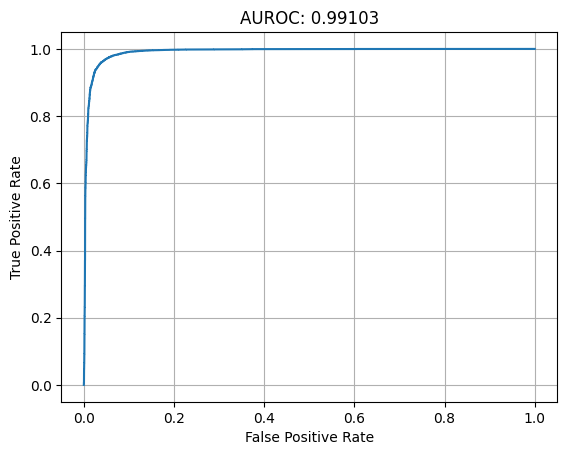

In [18]:
plot_roc(roc)

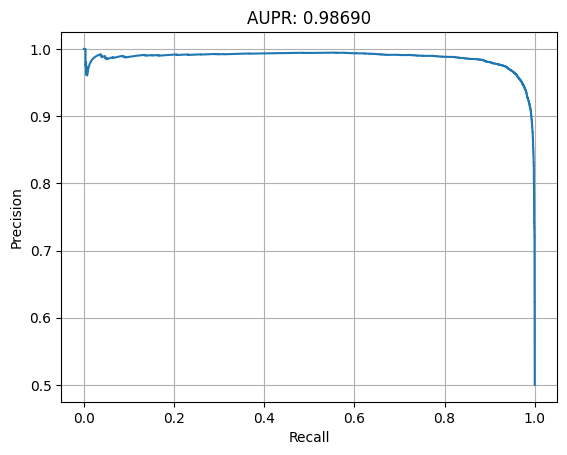

In [19]:
plot_pr(pr)

In [20]:
print(roc['thresholds'])

[           inf 9.56111504e-01 8.17656941e-01 ... 4.82684866e-08
 4.82449751e-08 1.82827560e-11]


In [21]:
print(pr['thresholds'])

[1.82827560e-11 2.24271105e-11 2.33441489e-11 ... 9.36872373e-01
 9.39087473e-01 9.56111504e-01]


In [22]:
np.savetxt('roc_thresholds.csv', roc['thresholds'], delimiter=',')

In [23]:
np.savetxt('pr_thresholds.csv', pr['thresholds'], delimiter=',')